In [1]:
# import libraries
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from icecube import icetray, dataclasses, dataio, recclasses
sys.path.append('/home/ahinners/.local/lib/python3.11/site-packages')
import simweights

In [2]:
# Load in IceCube CORSIKA Simulations
bigfilelist = '/data/sim/IceCube/2020/filtered/dst/CORSIKA-in-ice/20904'
corsika_fl = sorted(glob.glob(f'{bigfilelist}/*/*i3*'))
#0000000-0000999
corsika_fl = corsika_fl[:50]

In [3]:
weight_keys = [
    "CylinderLength",
    "CylinderRadius",
    "EnergyPrimaryMax",
    "EnergyPrimaryMin",
    "NEvents",
    "OverSampling",
    "ParticleType",
    "PrimaryEnergy",
    "PrimarySpectralIndex",
    "PrimaryType",
    "ThetaMax",
    "ThetaMin",
    "Weight",
]

particle_keys = ["type", "energy", "zenith"]

CorsikaWeightMap: dict = {k: [] for k in weight_keys}
PolyplopiaPrimary: dict = {k: [] for k in ["type", "energy", "zenith"]}
MCtype_corsika = np.array([])
MCenergy_corsika = np.array([])


In [4]:
#i = 0
for f in corsika_fl:
    #print("Reading", f)
    infile_corsika = dataio.I3File(f)
    while infile_corsika.more():
        frame = infile_corsika.pop_physics()

        #if i != 50:
        #    i += 1
        
        # Frame may contain coincident events so select injected primary shower 'PolyplopiaPrimary'
        MCtype_corsika = np.append(MCtype_corsika, frame["PolyplopiaPrimary"].type)
        MCenergy_corsika = np.append(MCenergy_corsika, frame["PolyplopiaPrimary"].energy)

        for k in weight_keys:
            CorsikaWeightMap[k].append(frame["CorsikaWeightMap"][k])

        PolyplopiaPrimary["zenith"].append(frame["PolyplopiaPrimary"].dir.zenith)
        PolyplopiaPrimary["type"].append(frame["PolyplopiaPrimary"].type)
        PolyplopiaPrimary["energy"].append(frame["PolyplopiaPrimary"].energy)
        #if i > 50:
        #    break
    #break

In [5]:
#print(CorsikaWeightMap)

In [6]:
# Set the weighter for the data
fobj = {"CorsikaWeightMap": CorsikaWeightMap, "PolyplopiaPrimary": PolyplopiaPrimary}
wobj = simweights.CorsikaWeighter(fobj, nfiles=len(corsika_fl))
fluxH = wobj.get_weights(simweights.GaisserH4a())
fluxG = wobj.get_weights(simweights.GlobalSplineFit())

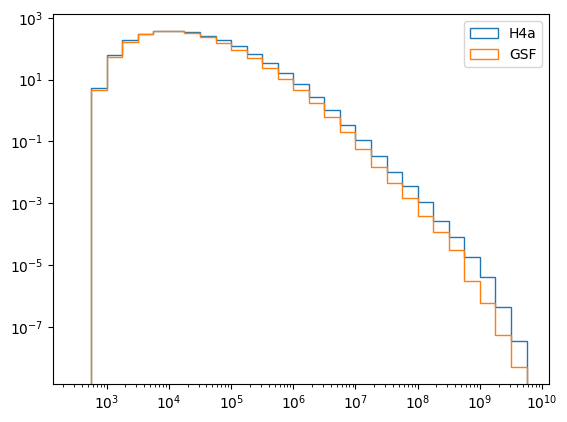

In [7]:
bins = 10**np.arange(2.5, 10, 0.25)
plt.hist(MCenergy_corsika, bins = bins, histtype="step", weights=fluxH, label="H4a")
plt.hist(MCenergy_corsika, bins=bins, histtype="step", weights=fluxG, label="GSF")
plt.loglog()
plt.legend()

In [8]:
# Set composition cuts
prot_cut = wobj.get_column('PolyplopiaPrimary', 'type') == 2.21200000e+03
eli_cut = wobj.get_column('PolyplopiaPrimary', 'type') == 1.00002004e+09
nit_cut = wobj.get_column('PolyplopiaPrimary', 'type') == 1.00007014e+09
alu_cut = wobj.get_column('PolyplopiaPrimary', 'type') == 1.00013027e+09
iron_cut = wobj.get_column('PolyplopiaPrimary', 'type') == 1.00026056e+09

primary_energy = wobj.get_column('PolyplopiaPrimary', 'energy')


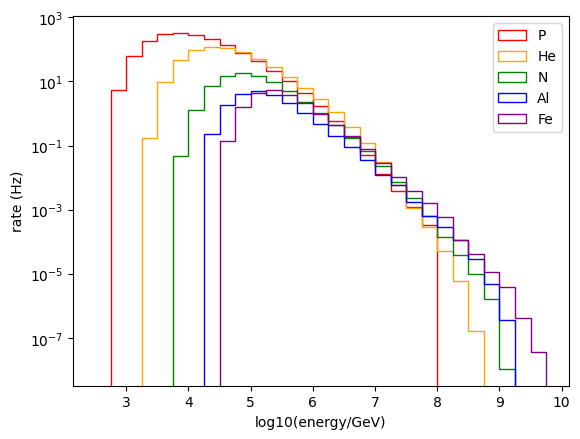

In [9]:
# Graph Log10 Energy vs Log 10 weighted counts

bins = np.arange(2.5, 10, 0.25)
#bins = np.arange(5, 8.5, 0.1)

# Plot the composition vs. log10 energy.
(pwtH, bins, patches1) = plt.hist(np.log10(primary_energy[prot_cut]), bins = bins, log = True, weights=fluxH[prot_cut], color = 'red',histtype = 'step', label ='P')
(hwtH, bins, patches1) = plt.hist(np.log10(primary_energy[eli_cut]), bins = bins, log = True, weights=fluxH[eli_cut], color = 'orange',histtype = 'step', label = 'He') 
(nwtH, bins, patches1) = plt.hist(np.log10(primary_energy[nit_cut]), bins = bins, log = True, weights=fluxH[nit_cut], color = 'green', histtype = 'step', label = 'N')
(awtH, bins, patches1) = plt.hist(np.log10(primary_energy[alu_cut]), bins = bins, log = True, weights=fluxH[alu_cut], color = 'blue', histtype = 'step', label = 'Al')
(iwtH, bins, patches1) = plt.hist(np.log10(primary_energy[iron_cut]), bins = bins, log=True, weights=fluxH[iron_cut], color='purple',histtype='step',label='Fe')
totH = pwtH + hwtH + nwtH + awtH + iwtH
#plt.hist(np.log10(primary_energy), bins = 50, log = True, weights=weights ,color = 'black', histtype = 'step', label = 'total')

plt.xlabel('log10(energy/GeV)')
plt.ylabel('rate (Hz)')
plt.legend()


/tmp/ipykernel_13868/3121377001.py:3: RuntimeWarning: invalid value encountered in divide
  pfracH4 = pwtH / totH
/tmp/ipykernel_13868/3121377001.py:4: RuntimeWarning: invalid value encountered in divide
  hfracH4 = hwtH / totH
/tmp/ipykernel_13868/3121377001.py:5: RuntimeWarning: invalid value encountered in divide
  nfracH4 = nwtH / totH
/tmp/ipykernel_13868/3121377001.py:6: RuntimeWarning: invalid value encountered in divide
  afracH4 = awtH / totH
/tmp/ipykernel_13868/3121377001.py:7: RuntimeWarning: invalid value encountered in divide
  ifracH4 = iwtH / totH


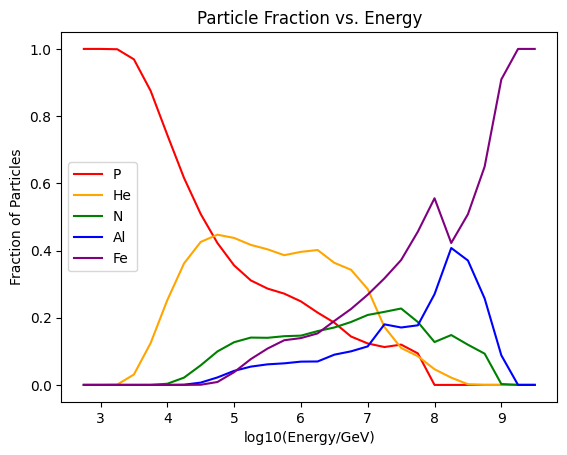

In [10]:
#attempts without dictionary

pfracH4 = pwtH / totH
hfracH4 = hwtH / totH
nfracH4 = nwtH / totH
afracH4 = awtH / totH
ifracH4 = iwtH / totH
plt.plot(bins[:-1], pfracH4, label = 'P', color='red')
plt.plot(bins[:-1], hfracH4, label = 'He', color='orange')
plt.plot(bins[:-1], nfracH4, label = 'N', color='green')
plt.plot(bins[:-1], afracH4, label = 'Al', color='blue')
plt.plot(bins[:-1], ifracH4, label = 'Fe', color='purple')

plt.xlabel('log10(Energy/GeV)')
plt.ylabel('Fraction of Particles')
plt.title('Particle Fraction vs. Energy')

plt.legend()

/tmp/ipykernel_13868/704114600.py:9: RuntimeWarning: invalid value encountered in divide
  meanZH = totZ / totH


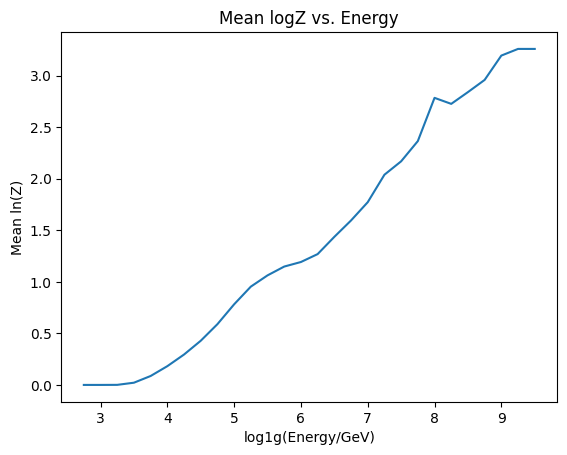

In [11]:
# Mean Atomic Charge (without dictionary)

PZ = pwtH * np.log(1)
HeZ = hwtH * np.log(2)
NZ = nwtH * np.log(7)
AlZ = awtH * np.log(13)
FeZ = iwtH * np.log(26)
totZ = PZ + HeZ + NZ + AlZ + FeZ
meanZH = totZ / totH
Mean_logZ_H4b = plt.plot(bins[:-1], meanZH)
plt.xlabel('log1g(Energy/GeV)')
plt.ylabel('Mean ln(Z)')
plt.title('Mean logZ vs. Energy')
plt.show()

In [12]:
# make a table of the overall percentage of particles
#
#pro_cent = len(primary_energy[CUTS['proton']])/len(primary_energy)
#eli_cent = len(primary_energy[CUTS['helium']])/len(primary_energy)
#oxy_cent = len(primary_energy[CUTS['oxygen']])/len(primary_energy)
#iro_cent = len(primary_energy[CUTS['iron']])/len(primary_energy)
#
#cent_table = [['proton', round(pro_cent, 3)], 
#              ['helium', round(eli_cent, 3)],
#              ['oxygen', round(oxy_cent, 3)],
#              ['iron', round(iro_cent, 3)]]
#
#for row in cent_table:
#    print(row)

In [13]:
#fluxG = simweights.GlobalSplineFit()
#weightG = weighter.get_weights(fluxG)

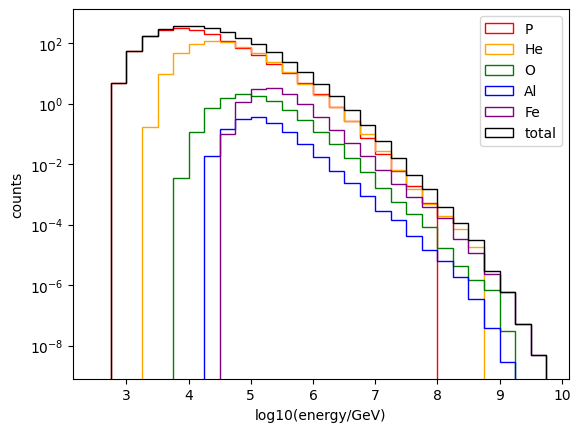

In [14]:
bins = np.arange(2.5, 10, 0.25)

(pwtG, bins, patches1) = plt.hist(np.log10(primary_energy[prot_cut]), bins = bins, log = True, weights=fluxG[prot_cut], color = 'red',histtype = 'step', label ='P')
(hwtG, bins, patches1) = plt.hist(np.log10(primary_energy[eli_cut]), bins = bins, log = True, weights=fluxG[eli_cut], color = 'orange',histtype = 'step', label = 'He') 
(nwtG, bins, patches1) = plt.hist(np.log10(primary_energy[nit_cut]), bins = bins, log = True, weights=fluxG[nit_cut], color = 'green', histtype = 'step', label = 'O')
(awtG, bins, patches1) = plt.hist(np.log10(primary_energy[alu_cut]), bins = bins, log = True, weights=fluxG[alu_cut], color = 'blue', histtype = 'step', label = 'Al')
(iwtG, bins, patches1) = plt.hist(np.log10(primary_energy[iron_cut]), bins = bins, log=True, weights=fluxG[iron_cut], color='purple',histtype='step',label='Fe')
totG = pwtG + hwtG + nwtG + awtG + iwtG
plt.hist(np.log10(primary_energy), bins = bins, log = True, weights=fluxG, color = 'black', histtype = 'step', label = 'total')

plt.xlabel('log10(energy/GeV)')
plt.ylabel('counts')
plt.legend()


/tmp/ipykernel_13868/2991688210.py:1: RuntimeWarning: invalid value encountered in divide
  pfracGSF = pwtG / totG
/tmp/ipykernel_13868/2991688210.py:2: RuntimeWarning: invalid value encountered in divide
  hfracGSF = hwtG / totG
/tmp/ipykernel_13868/2991688210.py:3: RuntimeWarning: invalid value encountered in divide
  nfracGSF = nwtG / totG
/tmp/ipykernel_13868/2991688210.py:4: RuntimeWarning: invalid value encountered in divide
  afracGSF = awtG / totG
/tmp/ipykernel_13868/2991688210.py:5: RuntimeWarning: invalid value encountered in divide
  ifracGSF = iwtG / totG


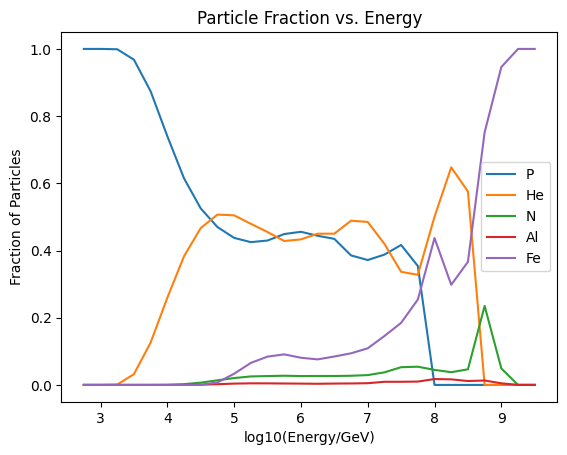

In [15]:
pfracGSF = pwtG / totG
hfracGSF = hwtG / totG
nfracGSF = nwtG / totG
afracGSF = awtG / totG
ifracGSF = iwtG / totG
plt.plot(bins[:-1], pfracGSF, label = 'P')
plt.plot(bins[:-1], hfracGSF, label = 'He')
plt.plot(bins[:-1], nfracGSF, label = 'N')
plt.plot(bins[:-1], afracGSF, label = 'Al')
plt.plot(bins[:-1], ifracGSF, label = 'Fe')

plt.xlabel('log10(Energy/GeV)')
plt.ylabel('Fraction of Particles')
plt.title('Particle Fraction vs. Energy')

plt.legend()


/tmp/ipykernel_13868/2175483964.py:7: RuntimeWarning: invalid value encountered in divide
  meanZG = totZ / totG


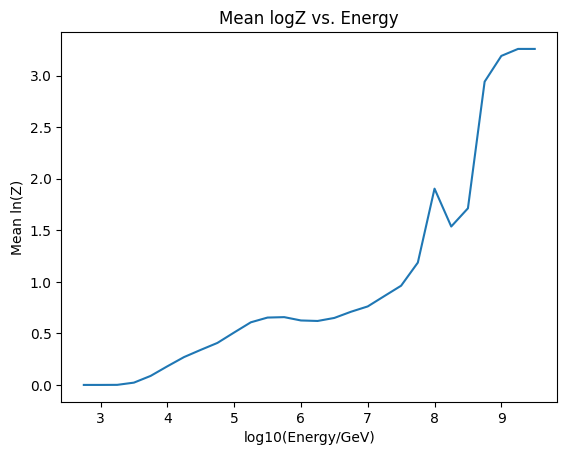

In [16]:
PZ = pwtG * np.log(1)
HeZ = hwtG * np.log(2)
NZ = nwtG * np.log(7)
AlZ = awtG * np.log(13)
FeZ = iwtG * np.log(26)
totZ = PZ + HeZ + NZ + AlZ + FeZ
meanZG = totZ / totG
Mean_logZ_GSF = plt.plot(bins[:-1], meanZG)
plt.xlabel('log10(Energy/GeV)')
plt.ylabel('Mean ln(Z)')
plt.title('Mean logZ vs. Energy')
plt.show()

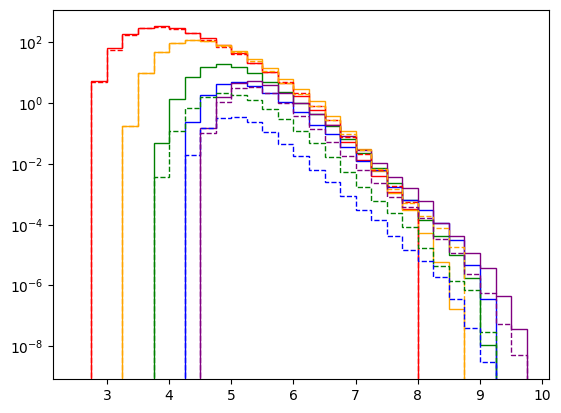

In [17]:
#bins = np.arange(2.5, 8.5, 0.25)

(pwtH, bins, patches1) = plt.hist(np.log10(primary_energy[prot_cut]), bins = bins, log = True, weights=fluxH[prot_cut], color = 'red',histtype = 'step', label ='P')
(hwtH, bins, patches1) = plt.hist(np.log10(primary_energy[eli_cut]), bins = bins, log = True, weights=fluxH[eli_cut], color = 'orange',histtype = 'step', label = 'He') 
(nwtH, bins, patches1) = plt.hist(np.log10(primary_energy[nit_cut]), bins = bins, log = True, weights=fluxH[nit_cut], color = 'green', histtype = 'step', label = 'N')
(awtH, bins, patches1) = plt.hist(np.log10(primary_energy[alu_cut]), bins = bins, log = True, weights=fluxH[alu_cut], color = 'blue', histtype = 'step', label = 'Al')
(iwtH, bins, patches1) = plt.hist(np.log10(primary_energy[iron_cut]), bins = bins, log=True, weights=fluxH[iron_cut], color='purple',histtype='step',label='Fe')

(pwtG, bins, patches1) = plt.hist(np.log10(primary_energy[prot_cut]), bins = bins, log = True, weights=fluxG[prot_cut], color = 'red',histtype = 'step', linestyle = '--', label ='P')
(hwtG, bins, patches1) = plt.hist(np.log10(primary_energy[eli_cut]), bins = bins, log = True, weights=fluxG[eli_cut], color = 'orange',histtype = 'step', linestyle = '--', label = 'He') 
(nwtG, bins, patches1) = plt.hist(np.log10(primary_energy[nit_cut]), bins = bins, log = True, weights=fluxG[nit_cut], color = 'green', histtype = 'step', linestyle = '--', label = 'O')
(awtG, bins, patches1) = plt.hist(np.log10(primary_energy[alu_cut]), bins = bins, log = True, weights=fluxG[alu_cut], color = 'blue', histtype = 'step', linestyle = '--', label = 'Al')
(iwtG, bins, patches1) = plt.hist(np.log10(primary_energy[iron_cut]), bins = bins, log=True, weights=fluxG[iron_cut], color='purple',histtype='step', linestyle = '--', label='Fe')


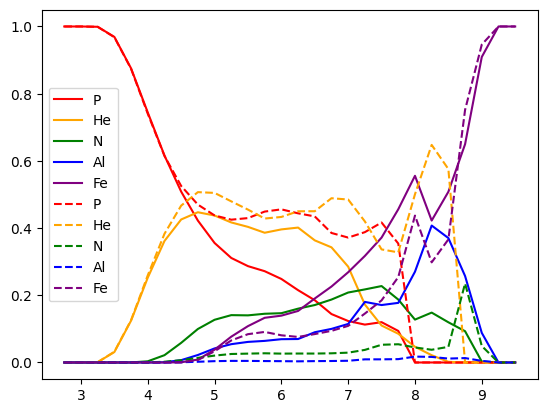

In [18]:
# Fractional Plots with GaaisserH4a_IT weighter
plt.plot(bins[:-1], pfracH4, label = 'P', color='red')
plt.plot(bins[:-1], hfracH4, label = 'He', color='orange')
plt.plot(bins[:-1], nfracH4, label = 'N', color='green')
plt.plot(bins[:-1], afracH4, label = 'Al', color='blue')
plt.plot(bins[:-1], ifracH4, label = 'Fe', color='purple')

# Fractional Plots with GlobalSplineFit_IT weighter
plt.plot(bins[:-1], pfracGSF, label = 'P', linestyle = '--', color='red')
plt.plot(bins[:-1], hfracGSF, label = 'He', linestyle='--', color='orange')
plt.plot(bins[:-1], nfracGSF, label = 'N', linestyle='--', color='green')
plt.plot(bins[:-1], afracGSF, label = 'Al', linestyle='--', color='blue')
plt.plot(bins[:-1], ifracGSF, label = 'Fe', linestyle='--', color='purple')

plt.legend()

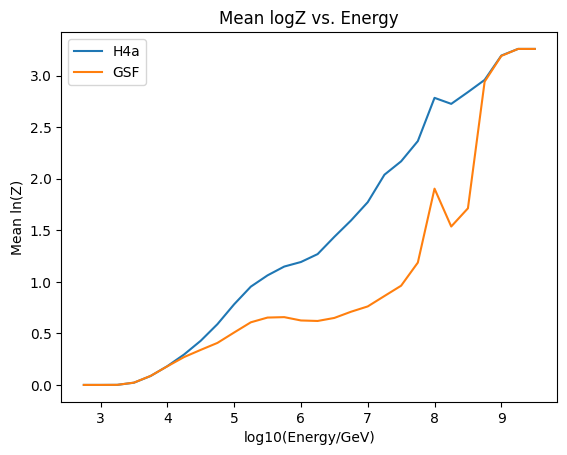

In [19]:
Mean_logZ_H4b = plt.plot(bins[:-1], meanZH, label = 'H4a')
Mean_logZ_GSF = plt.plot(bins[:-1], meanZG, label = 'GSF')
plt.xlabel('log10(Energy/GeV)')
plt.ylabel('Mean ln(Z)')
plt.title('Mean logZ vs. Energy')
plt.legend()
plt.show()